In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from ..utils import drawPoints, epilinePlot

In [2]:
def imshow(img, size=None):
    if size == None:
        plt.figure(figsize=(14,18))
    else:
        plt.figure(figsize=size)
    plt.imshow(img)
    plt.show()

def imshow2(img):
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
imgl_pts = np.load('blob_loc_left.npy')
imgr_pts = np.load('blob_loc_right.npy')

imgsl = glob.glob('./data_F/cam2/*.png')
imgsr = glob.glob('./data_F/cam1/*.png')

imgsl.sort()
imgsr.sort()

In [3]:
# Filtering duplicated images
rerange1 = list(range(122, 133))
rerange2 = list(range(361, 389))
rerange3 = list(range(506, 523))
rerange4 = list(range(625, 642))
rerange5 = list(range(649, 656))
rerange6 = list(range(678, 741))

#
rerange1 = list(range(123, 134))
rerange2 = list(range(362, 390))
rerange3 = list(range(507, 524))
rerange4 = list(range(626, 643))
rerange5 = list(range(650, 657))
rerange6 = list(range(679, 742))

## Tools for corresponding points marking

In [ ]:
class ptCoord:
    def __init__(self):
        self.points = []

    def click_and_mark(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.points.append((x,y))
    
    def reset(self):
        self.points = []
        
        
ptl = ptCoord()
ptr = ptCoord()

pt_left = {}
pt_right = {}
cnt = 0
for imgl, imgr in zip(imgsl, imgsr):
    
    img_left = cv2.imread(imgl)
    cv2.namedWindow('imgLeft')
    cv2.setMouseCallback('imgLeft', ptl.click_and_mark)
    cv2.imshow('imgLeft',img_left)
    
    k = cv2.waitKey(0) & 0xFF
    if k == ord('a'):
        pt_left[cnt] = ptl.points
        ptl.reset()
    cv2.destroyAllWindows()
    
    img_right = cv2.imread(imgr)
    cv2.namedWindow('imgRight')
    cv2.setMouseCallback('imgRight', ptr.click_and_mark)
    cv2.imshow('imgRight', img_right)
    
    k = cv2.waitKey(0) & 0xFF
    if k == ord('a'):
        pt_right[cnt] = ptr.points
        ptr.reset()
    cv2.destroyAllWindows()
    cnt += 1

In [4]:
# save the recorded points
#np.save('./data_F/ptsL400_out.npy', pt_left)
#np.save('./data_F/ptsR400_out.npy', pt_right)

In [ ]:
idx = 19
pts = pt_left[idx]
pts = np.array(pts)
img = cv2.imread(imgsl[idx])
for pt in pts:
    img = cv2.circle(img, tuple(pt), 2, (0,255,0), -1)
imshow2(img)

In [4]:
# Load template poitns
pts_F_left = []
pts_F_right = []
for ele in imgl_pts:
    pts_F_left.append(ele[0])
for ele in imgr_pts:
    pts_F_right.append(ele[0])

# Load image points 
pt_left = np.load('./data_F/ptsL200.npy').item()
pt_right = np.load('./data_F/ptsR200.npy').item()
for i in range(len(pt_left)):
    ptL = pt_left[i]
    ptR = pt_right[i]
    if len(ptL) == len(ptR):
        for elel, eler in zip(ptL, ptR):
            pts_F_left.append(elel)
            pts_F_right.append(eler)

pts_F_left = np.array(pts_F_left)
pts_F_right = np.array(pts_F_right)

In [22]:
# Load template poitns 400
pts_F_left = []
pts_F_right = []
for ele in imgl_pts:
    pts_F_left.append(ele[0])
for ele in imgr_pts:
    pts_F_right.append(ele[0])

# Load image points 
pt_left = np.load('./data_F/ptsL400_inner.npy').item()
pt_right = np.load('./data_F/ptsR400_inner.npy').item()
for i in pt_left.keys():
    ptL = pt_left[i]
    ptR = pt_right[i]
    pts_F_left.append(ptL)
    pts_F_right.append(ptR)

pts_F_left = np.array(pts_F_left)
pts_F_right = np.array(pts_F_right)

In [5]:
# Estimate fundamental matrix
F, mask = cv2.findFundamentalMat(pts_F_left, pts_F_right, cv2.FM_LMEDS) #FM_RANSAC FM_LMEDS

## Epiline Test

In [31]:
# test on images
idx = 0
imgl = cv2.imread('../../data/CTR_Robot/Camera2/cam2_500.png')
imgr = cv2.imread('../../data/CTR_Robot/Camera1/cam1_500.png')
#imgl = cv2.imread('../segmentation/seg_result/seg' + str(index) + '_r.png')
#imgr = cv2.imread('../segmentation/seg_result/seg' + str(index) + '_l.png')

class ptCoord:
    def __init__(self):
        self.points = (0,0)

    def click_and_mark(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.points = (x,y)

pt = ptCoord()

while True:
    cv2.namedWindow('imgLeft')
    cv2.namedWindow('imgRight')
    cv2.setMouseCallback('imgLeft', pt.click_and_mark)
    cv2.imshow('imgLeft',imgr)
    cv2.imshow('imgRight', imgl)
    #print(pt.points)
    k = cv2.waitKey(20) & 0xFF
    if k == 27:
        break
    elif k == ord('a'):
        imgl_undist, imgr_undist = epilinePlot(np.array([pt.points]), imgr, imgl, F, 2)
cv2.destroyAllWindows()

## Projection Matrix Calculation

In [8]:
coeff_left = np.load('calibration_coeff_left.npy').item()
kl = coeff_left['intr_mat']

coeff_right = np.load('calibration_coeff_right.npy').item()
kr = coeff_right['intr_mat']

# Estimate essential matrix
E = np.matmul(np.matmul(kr.T, F), kl)
U, S, Vt = np.linalg.svd(E)
# Tweak S
diag = np.array([[1, 0, 0],[0, 1, 0], [0, 0, 0]])
E_new = np.matmul(np.matmul(U, diag), Vt)
Un, Sn, Vtn = np.linalg.svd(E_new)
# Define W and Wt
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
Wt = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])

# 2 possible solutions for Rotation and Translation
R1 = np.matmul(np.matmul(Un, W), Vtn)
R2 = np.matmul(np.matmul(Un, Wt), Vtn)
T1 = Un[:,2].reshape(3,1)
T2 = -Un[:,2].reshape(3,1)

# 4 Possible projection matrix for right camera
PR1 = np.hstack((R1, T1))
PR2 = np.hstack((R1, T2))
PR3 = np.hstack((R2, T1))
PR4 = np.hstack((R2, T2))

# Initialize Left projection matrix
PL = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])

## Save calculated Params

In [9]:
data = {
    'F':F,
    'R1':R1,
    'T1':T1,
    'R2':R2,
    'T2':T2,
    'PL':PL,
}

np.save('triangulate_coeff.npy', data)

In [17]:
a, b = cv2.Rodrigues(R2)
a

array([[-0.00535312],
       [-2.35072835],
       [ 0.25793332]])

In [13]:
# Verify fundamental matrix results
test_left = []
test_right = []
for ele in imgl_pts:
    test_left.append(ele[0])
for ele in imgr_pts:
    test_right.append(ele[0])
test_left = np.array(test_left)
test_right = np.array(test_right)
test_left = np.hstack((test_left, np.ones((len(test_left),1))))
test_right = np.hstack((test_right, np.ones((len(test_right),1))))

res = np.matmul(np.matmul(test_right, F), test_left.T)
res = np.diag(res)
res

array([ 1.66910552e-03, -1.02138823e-04, -1.82244025e-03, -3.28848445e-03,
        1.54056536e-03,  3.16356806e-04, -1.01147058e-03, -2.01744020e-03,
        2.91611430e-03,  1.93155435e-03,  8.92267358e-04, -9.23705556e-14,
        3.22482508e-03,  2.47983532e-03,  2.10237284e-03,  1.54577878e-03,
        4.04851301e-03,  3.65647615e-03,  3.36134324e-03,  3.40957210e-03,
        4.71371922e-03,  4.71432891e-03,  4.89718578e-03,  5.04423624e-03,
        4.98186930e-03,  5.55447461e-03,  6.15949411e-03,  6.49104354e-03,
        5.82283540e-03,  6.79081531e-03,  7.67347727e-03,  8.48702136e-03,
        5.77019206e-03,  7.02814613e-03,  8.27959686e-03,  9.59971661e-03])

In [77]:
from FindCorrespondPts import findCorrespondPts

imgl_pts = np.load('blob_loc_left.npy')
imgr_pts = np.load('blob_loc_right.npy')
coeff_left = np.load('calibration_coeff_left.npy').item()
kl = coeff_left['intr_mat']

coeff_right = np.load('calibration_coeff_right.npy').item()
kr = coeff_right['intr_mat']

trian_param = np.load('triangulate_coeff.npy').item()

F = trian_param['F']
# 2 possible solutions for Rotation and Translation
R1 = trian_param['R1']
R2 = trian_param['R2']
T1 = trian_param['T1']
T2 = trian_param['T2']

# 4 Possible projection matrix for right camera
PR1 = np.hstack((R1, T1))
PR2 = np.hstack((R1, T2))
PR3 = np.hstack((R2, T1))
PR4 = np.hstack((R2, T2))

# Initialize Left projection matrix
PL = trian_param['PL']


PR = PR4

# Calculate template points
PR_cal = np.matmul(kr, PR)
PL_cal = np.matmul(kl, PL)


index = 30
# be careful about coordinate representation
sample_num = 100

# Find points to be triangulated in left image 
img_left = cv2.imread('../segmentation/seg_result/seg' + str(index) + '_r.png')
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)

img_right = cv2.imread('../segmentation/seg_result/seg' + str(index) + '_l.png')
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

# Corresponding points
ptsL, ptsR = findCorrespondPts(img_left, img_right, F, sampleSize = 50, thresh = 0.5)

# Triangulated points
pts = cv2.triangulatePoints(PL_cal, PR_cal, ptsL, ptsR).T
pts3D = cv2.convertPointsFromHomogeneous(pts).T[:,0]

temp = cv2.triangulatePoints(PL_cal, PR_cal, imgl_pts, imgr_pts).T
temp3D = cv2.convertPointsFromHomogeneous(temp).T[:,0]

In [78]:
loc1 = np.array([[0],[0],[0]])
loc2 = np.matmul(R2, loc1 + T2)

<IPython.core.display.Javascript object>


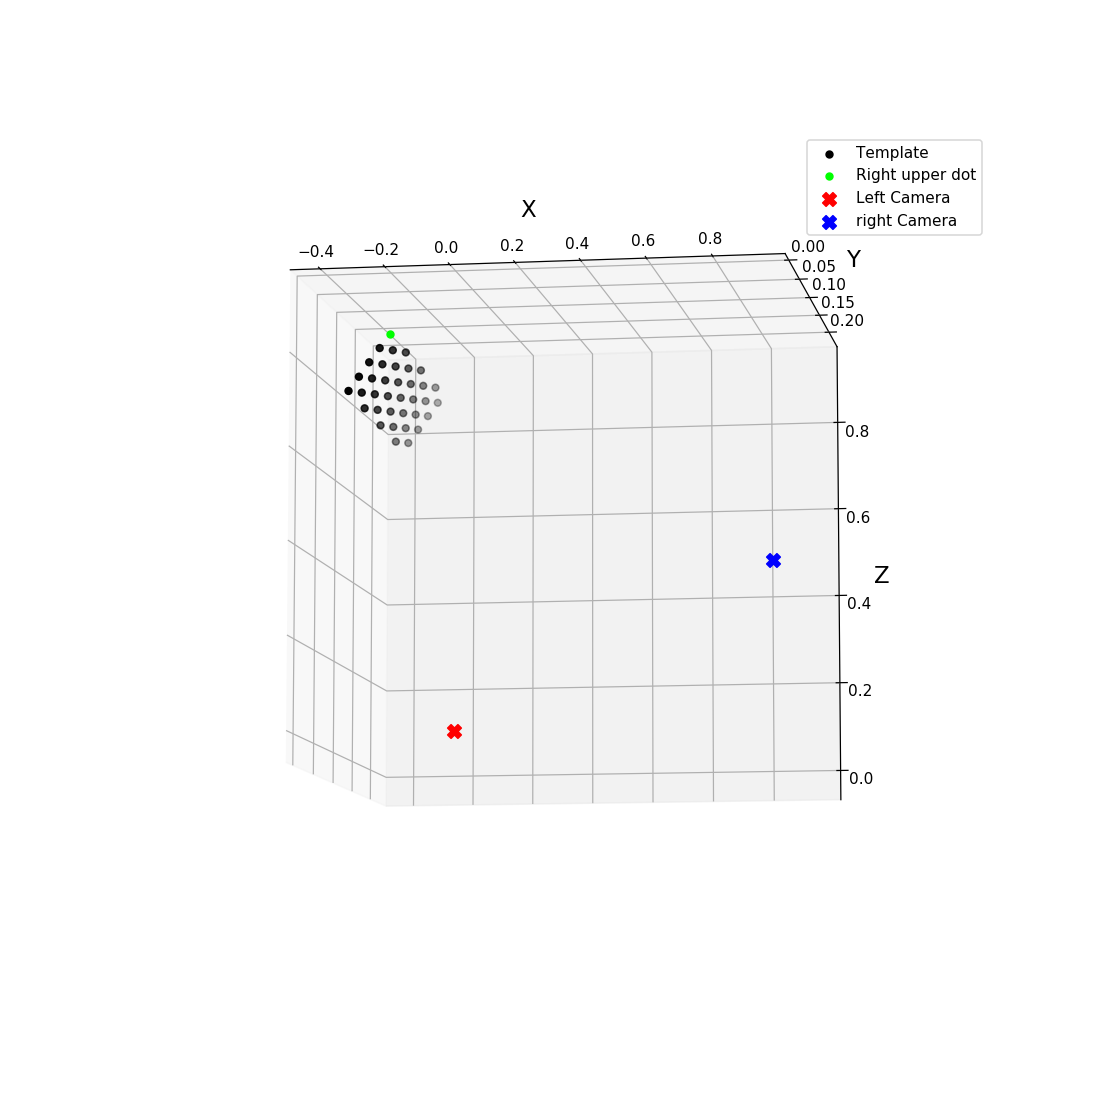

In [79]:
from mpl_toolkits.mplot3d import Axes3D

# The third solution of right projection matrix
Xs = pts3D[0]
Ys = pts3D[1]
Zs = pts3D[2]

Xs_tp = temp3D[0]
Ys_tp = temp3D[1]
Zs_tp = temp3D[2]

#Ys = res3D[0]
#Zs = res3D[1]
#Xs = res3D[2]

%matplotlib notebook
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(Xs, Ys, Zs)
ax.scatter(Xs_tp[1::], Ys_tp[1::], Zs_tp[1::], c = 'black', label = 'Template')

idx = 0
#ax.scatter(Xs[idx], Ys[idx], Zs[idx], c='red', marker='x')
ax.scatter(Xs_tp[idx], Ys_tp[idx], Zs_tp[idx], c='lime', marker='o', label = 'Right upper dot')

ax.scatter(loc1[0], loc1[1], loc1[2], c='red', marker='X', s=80, label = 'Left Camera')
ax.scatter(loc2[0], loc2[1], loc2[2], c='blue', marker='X', s=80, label = 'right Camera')

#ax.set_xlim([-0.8, 0.8])
#ax.set_ylim([0,0.4])
#ax.set_zlim([0, 1])
ax.set_xlabel('X', fontsize = 15)
ax.set_ylabel('Y', fontsize = 15)
ax.set_zlabel('Z', fontsize = 15)
plt.legend(loc = 0)
#plt.title('Camera Locations and Reference Temaplates', fontsize = 18)
#
plt.show()

In [80]:
plt.savefig('projectMat4.pdf', bbox_inches='tight')

In [ ]:
img_right = cv2.imread('../segmentation/seg_result/seg' + str(index) + '_l.png')
def drawlines(img, lines):
    _, c, _ = img.shape
    for r in lines:
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        cv2.line(img, (x0, y0), (x1, y1), (0,255,0), 1)
    return img
        
img = drawlines(img_right, lines)
imshow2(img)

In [77]:
# Checking distance between adjacent points
for idx in range(len(Xs_tp)-1):
    xd = (Xs_tp[idx]-Xs_tp[idx+1])**2
    yd = (Ys_tp[idx]-Ys_tp[idx+1])**2
    zd = (Zs_tp[idx]-Zs_tp[idx+1])**2
    print(np.sqrt(xd+yd+zd))

0.04363055384830523
0.043632410167336995
0.04367829288435214
0.11128287009070051
0.0435194911459774
0.04371054043112344
0.04370762695531555
0.1542122131830186
0.043499934856038425
0.04354364004098207
0.04350576575853636
0.11092363992145744
0.04337568975510417
0.04358910863505845
0.04345798470396038
0.15375698755539693
0.04344631447186939
0.04333827675136587
0.043596056565391485
0.11084000273646745
0.043253596174447136
0.04342262869717029
0.043322307944993824
0.15330634461290388
0.04336854506696238
0.04312428503353949
0.0435240625939762
0.11052987480773283
0.043214492916202184
0.043169639447080674
0.043247483380803864
0.15290197890745058
0.04319408886176874
0.043101830586671594
0.04332628488808782


In [36]:
# Checking length of inner tube
pts = pts3D.T
l = 0
for idx in range(len(pts)-1):
    dx = pts[idx+1][0] - pts[idx][0]
    dy = pts[idx+1][1] - pts[idx][1]
    dz = pts[idx+1][2] - pts[idx][2]
    l += np.sqrt(dx**2+dy**2+dz**2)
l*18.2/0.043

206.55664438803328

## Marking 400 image pairs

In [9]:
rerange1 = list(range(123, 134))
rerange2 = list(range(362, 390))
rerange3 = list(range(507, 524))
rerange4 = list(range(626, 643))
rerange5 = list(range(650, 657))
rerange6 = list(range(679, 742))

filt = rerange1 + rerange2 + rerange3 + rerange4 + rerange5 + rerange6

class ptCoord:
    def __init__(self):
        self.points = (0,0)

    def click_and_mark(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.points = (x,y)
    
    def reset(self):
        self.points = (0,0)

ptl = ptCoord()
ptr = ptCoord()
pt_left = {}
pt_right = {}

for i in range(400,801):
    if i not in filt:
        imgl = '../../data/CTR_Robot/Camera2/cam2_' + str(i) + '.png'
        imgr = '../../data/CTR_Robot/Camera1/cam1_' + str(i) + '.png'
    
        img_left = cv2.imread(imgl)
        cv2.namedWindow('imgLeft')
        cv2.setMouseCallback('imgLeft', ptl.click_and_mark)
        cv2.imshow('imgLeft',img_left)

        k = cv2.waitKey(0) & 0xFF
        if k == ord('a'):
            pt_left[i] = ptl.points
            ptl.reset()
        cv2.destroyAllWindows()

        img_right = cv2.imread(imgr)
        cv2.namedWindow('imgRight')
        cv2.setMouseCallback('imgRight', ptr.click_and_mark)
        cv2.imshow('imgRight', img_right)

        k = cv2.waitKey(0) & 0xFF
        if k == ord('a'):
            pt_right[i] = ptr.points
            ptr.reset()
        cv2.destroyAllWindows()

In [10]:
np.save('./data_F/ptsL4-800_out.npy', pt_left)
np.save('./data_F/ptsR4-800_out.npy', pt_right)

In [11]:
len(pt_left)

285

In [12]:
len(pt_right)

250

In [5]:
test_left = []
test_right = []
for ele in imgl_pts:
    test_left.append(ele[0])
for ele in imgr_pts:
    test_right.append(ele[0])
test_left = np.array(test_left)
test_right = np.array(test_right)
test_left = np.hstack((test_left, np.ones((len(test_left),1))))
test_right = np.hstack((test_right, np.ones((len(test_right),1))))


array([[394.14004517, 431.96081543,   1.        ],
       [392.96542358, 468.37417603,   1.        ],
       [391.61868286, 505.56359863,   1.        ],
       [389.90039062, 543.6418457 ,   1.        ],
       [377.85125732, 449.01776123,   1.        ],
       [376.89193726, 486.43057251,   1.        ],
       [374.78979492, 524.86773682,   1.        ],
       [373.03466797, 564.15887451,   1.        ],
       [362.48168945, 429.15124512,   1.        ],
       [361.21853638, 466.87579346,   1.        ],
       [359.17105103, 505.51593018,   1.        ],
       [357.36904907, 544.95068359,   1.        ],
       [344.70379639, 446.87097168,   1.        ],
       [343.20321655, 485.62454224,   1.        ],
       [340.85183716, 525.60675049,   1.        ],
       [338.83682251, 566.24530029,   1.        ],
       [328.32177734, 426.04672241,   1.        ],
       [326.24945068, 465.31030273,   1.        ],
       [324.19128418, 505.36108398,   1.        ],
       [321.76638794, 546.64428